# A Comparision Between Complete State Tomography and Shadow Tomography

## What is Complete State Tomography?

### Overview

The aim of complete state tomography is to reconstruct a target quantum state through a series of projective measurements. *Mention Born's rule, destruction of a state due to measurement, and the curse of dimensionality.*

### Theory

For single-qubit states the general expression for their density matrices can be written uniquely as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} S_i \hat{\sigma}_i. \tag{1}$$
Where $\hat{\sigma}_i$ are the Pauli matrices (Including the 2x2 identity matrix as $\hat{\sigma}_0$) and $S_i$ are the values given by:
$$S_i = Tr\{\hat{\sigma}_i\hat{\rho}\}. \tag{2}$$
It is also useful to note that, 
1. For all pure states: $\sum_{i=1}^{3} S_i^2 = 1$.
2. For mixed states: $\sum_{i=1}^{3} S_i^2 < 1$.
3. For the completely mixed state:  $\sum_{i=1}^{3} S_i^2 = 0$.
4. Due to the normalization condition for quantum states it is always the case that: $S_0^2 = 1$.

The above contents are from pages 4 and 5 of [Quantum State Tomography](#references). Proofs of (1) and (2) to be added in the future.

For a quantum state represented by density matrix $\hat{\rho}$ the expectation value for an observable $\hat{\Omega}$ is given by:
$$\langle \hat{\Omega} \rangle = \sum_{i} p_i \bra{i} \hat{\Omega} \ket{i} = Tr \{ \hat{\Omega} \hat{\rho} \}. \tag{3}$$
Thus, using (1) and (3), we can represent the density matrix for a single-qubit state as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} \langle \hat{\sigma}_i \rangle \hat{\sigma}_i. \tag{4}$$

For multiple-qubit states the general expression for their density matrices can be written as:
$$ \hat{\rho} = \frac{1}{2^n} \sum_{i_1,i_2,\dots,i_n = 0}^{3} S_{i_1,i_2,\dots,i_n} \hat{\sigma_{i_1}} \otimes \hat{\sigma_{i_2}} \otimes \dots \hat{\sigma_{i_n}}. \tag{5}$$
Where $\hat{\sigma}_i$ are still the Pauli matrices (Including the 2x2 identity matrix as $\hat{\sigma}_0$) and $S_{i_1,i_2,\dots,i_n}$ are the values given by:
$$ S_{i_1,i_2,\dots,i_n} = Tr\{ \hat{\sigma}_{i_1,i_2,\dots,i_n} \hat{\rho} \} = Tr\{ (\hat{\sigma_{i_1}} \otimes \hat{\sigma_{i_2}} \otimes \dots \hat{\sigma_{i_n}}) \hat{\rho} \} \tag{6}$$

The above contents are from page 11 of [Quantum State Tomography](#references).

> Note: Above we only considered the orthogonal measurement bases of the pauli matrices. We are not constrained to orthogonal measurement bases and can instead use any set of linearly independent projective measurements (see pages 5 and 6 of [Quantum State Tomography](#references) for the single-qubit case and pages 11 and 12 of [Quantum State Tomography](#references) for the multiple-qubit case.).

### The "Algorithm"

#### Importing necessary libraries

In [506]:
import numpy as np
import itertools

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Clbit
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import DensityMatrix

#### Function for generating an approximation of the $\rho$ prepared by the input circuit using complete state tomography as describe in [Quantum State Tomography](#references)

In [507]:
def complete_state_tomography(circuit, samples, num_qubits):
    """
    Perform complete state tomography on a state prepared by a quantum circuit.

    Args:
        circuit (QuantumCircuit): The quantum circuit that prepares the state.
        samples (int): The number of samples to use in the tomography.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.ndarray: The density matrix of the state.
    """

    # The Pauli matrices.
    I = [[1,0],[0,1]]
    X = [[0,1],[1,0]]
    Y = [[0,-1j],[1j,0]]
    Z = [[1,0],[0,-1]]

    # Create a matrix to store the density matrix.
    rho = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    # Generate the measurement scheme using the cartesian product.
    measurement_scheme = itertools.product([0,1,2,3], repeat=num_qubits)

    for m in measurement_scheme:
        print(m)

    # An array to store the measurement results.
    results = np.zeros(4**num_qubits)

    # Create a sampler to simulate the quantum circuit on a single shot.
    sampler = StatevectorSampler(default_shots=samples)

    # Perform the measurements.
    for n, measurement in enumerate(measurement_scheme):
        # The identity measurement is a special case that always has a coefficient of 1 (due to normalization).
        if(measurement == len(measurement) * (0,)):
            results[n] = 1
            continue

        meas_circuit = circuit.copy()
        cr = ClassicalRegister(size = (num_qubits - measurement.count(0)), name = 'c')
        meas_circuit.add_register(cr)
        cbit_count = 0
        for m, i in enumerate(measurement):
            match i:
                case 0:
                    continue
                case 1:
                    meas_circuit.h(m)
                    meas_circuit.measure(m, cbit_count)
                    cbit_count += 1
                case 2:
                    meas_circuit.h(m)
                    meas_circuit.sdg(m)
                    meas_circuit.measure(m, cbit_count)
                    cbit_count += 1
                case 3:
                    meas_circuit.measure(m, cbit_count)
                    cbit_count += 1
        
        # Run the sampler on the quantum circuit and store the result.
        result = sampler.run([meas_circuit]).result()[0]

        # Store the bitstrings representing the measured basis states.
        counts = result.data.c.get_counts()   

        # Calculate the expectation value of the measurement.
        for key, value in counts.items():
            if (key == len(key) * '0'):
                results[n] = value/samples
                break
            else:
                results[n] = 0
        
        # Calculate the density matrix.
        for i, measurement in enumerate(measurement_scheme):
            o = [1]
            for j in measurement:
                match j:
                    case 0:
                        o = np.kron(o, I)
                    case 1:
                        o = np.kron(o, X)
                    case 2:
                        o = np.kron(o, Y)
                    case 3:
                        o = np.kron(o, Z)
            rho += results[i] * o

    return rho/2**num_qubits

### Examples

#### With a Bell state

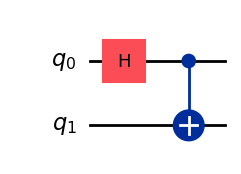

In [508]:
num_qubits = 2
bell_state = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]

# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (num_qubits, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [510]:
rho_true = DensityMatrix.from_instruction(bell_state_qc)
print(rho_true)

rho_tomo = complete_state_tomography(bell_state_qc, 1000, num_qubits)
print(rho_tomo)

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
              dims=(2, 2))
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


## What is Shadow Tomography?

### Theory

## The Method of Classical Shadows

## The Single Qubit Case

## The Two Qubit Case

## The Three Qubit Case

## References
1. [Predicting Many Properties of a Quantum System from Very Few Measurements](https://arxiv.org/pdf/2002.08953)
2. [Quantum State Tomography](https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf)
3. [PennyLane Classical Shadows Demo](https://pennylane.ai/qml/demos/tutorial_classical_shadows/#huang2020)